# Purity Network
Quantum Neural Network (QNN) that compute the purity of a given state

In [1]:
import os
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
from IPython.display import clear_output

import tensorflow as tf

import strawberryfields as sf
from strawberryfields.ops import *

from state_preparation import state_preparation_network, layer

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
np.random.seed(42)
tf.set_random_seed(42)

## Constants

### Dataset

In [4]:
data_folder = "data_one_qumode"

n_qumodes_rho = 1
n_qumodes_psi = n_qumodes_rho * 2 # for purification
n_qumodes_pn = n_qumodes_rho * 2 # input: [ρ, ρ]
n_qumodes_total = n_qumodes_psi * 2

cutoff = 3
size_hilbert = cutoff**n_qumodes_rho

ratio_train = 0.75

### State network

In [5]:
n_layers_sp = 20

### Purity Network

In [6]:
n_layers_pn = 10
batch_size_pn = 16

passive_std = 0.1
active_std = 0.001

## Loading the dataset

### Loading the files

In [7]:
rhos = np.load(os.path.join(data_folder, "rhos.npy"))
purities = np.load(os.path.join(data_folder, "purities.npy"))
list_params = np.load(os.path.join(data_folder, "list_params.npy"))

In [8]:
n_samples = len(rhos)
n_samples_train = int(ratio_train*n_samples)
n_samples_test = n_samples - n_samples_train

In [9]:
samples_idx = np.random.choice(n_samples, size=n_samples, replace=False)
rhos = rhos[samples_idx]
purities = purities[samples_idx]
list_params = list_params[samples_idx]

### Dividing train and test

In [10]:
X_train = list_params[:n_samples_train]
X_test = list_params[n_samples_train:]

Y_train = purities[:n_samples_train]
Y_test = purities[n_samples_train:]
print(len(X_train))

300


## Placeholders

#### State network
The parameters of the first network are the actual input of the network

In [11]:
# squeeze gate
sp_sq_r = tf.placeholder(tf.float32, [n_layers_sp, n_qumodes_psi], name="sp_sq_r")
sp_sq_phi = tf.placeholder(tf.float32, [n_layers_sp, n_qumodes_psi], name="sp_sq_phi")

# displacement gate
sp_d_r = tf.placeholder(tf.float32, [n_layers_sp, n_qumodes_psi], name="sp_d_r")
sp_d_phi = tf.placeholder(tf.float32, [n_layers_sp, n_qumodes_psi], name="sp_d_phi")

# interferometer
sp_inter_theta = tf.placeholder(tf.float32, [n_layers_sp*2, int(n_qumodes_psi*(n_qumodes_psi-1)/2)], name="sp_inter_theta")
sp_inter_phi = tf.placeholder(tf.float32, [n_layers_sp*2, int(n_qumodes_psi*(n_qumodes_psi-1)/2)], name="sp_inter_phi")
sp_inter_rphi = tf.placeholder(tf.float32, [n_layers_sp*2, n_qumodes_psi-1], name="sp_inter_rphi")

# kerr gate
sp_kappa = tf.placeholder(tf.float32, [n_layers_sp, n_qumodes_psi], name="sp_kappa")

In [12]:
sp_params = [sp_sq_r, sp_sq_phi, sp_d_r, sp_d_phi, sp_inter_theta, sp_inter_phi, sp_inter_rphi, sp_kappa]

In [13]:
def get_feed_dict(params):
    return {sp_sq_r: np.array(list(params[0])),
            sp_sq_phi: np.array(list(params[1])),
            sp_d_r: np.array(list(params[2])),
            sp_d_phi: np.array(list(params[3])),
            sp_inter_theta: np.array(list(params[4])),
            sp_inter_phi: np.array(list(params[5])),
            sp_inter_rphi: np.array(list(params[6])),
            sp_kappa: np.array(list(params[7]))}

#### Purity network

In [14]:
purity_input = tf.placeholder(tf.float32, name="purity")
lr_placeholder = tf.placeholder(tf.float32, name="lr_placeholder")

## Purity Network

### Parameters

In [15]:
# Initial parameters

# squeeze gate
pn_sq_r = tf.Variable(tf.random_normal(shape=[n_layers_pn, n_qumodes_pn], stddev=active_std))
pn_sq_phi = tf.Variable(tf.random_normal(shape=[n_layers_pn, n_qumodes_pn], stddev=passive_std))

# displacement gate
pn_d_r = tf.Variable(tf.random_normal(shape=[n_layers_pn, n_qumodes_pn], stddev=active_std))
pn_d_phi = tf.Variable(tf.random_normal(shape=[n_layers_pn, n_qumodes_pn], stddev=passive_std))

# interferometer
pn_inter_theta = tf.Variable(tf.random_normal(shape=[n_layers_pn*2, int(n_qumodes_pn*(n_qumodes_pn-1)/2)], stddev=passive_std))
pn_inter_phi = tf.Variable(tf.random_normal(shape=[n_layers_pn*2, int(n_qumodes_pn*(n_qumodes_pn-1)/2)], stddev=passive_std))
pn_inter_rphi = tf.Variable(tf.random_normal(shape=[n_layers_pn*2, n_qumodes_pn-1], stddev=passive_std))

# kerr gate
pn_kappa = tf.Variable(tf.random_normal(shape=[n_layers_pn, n_qumodes_pn*2], stddev=active_std))

In [16]:
pn_params = [pn_sq_r, pn_sq_phi, pn_d_r, pn_d_phi, pn_inter_theta, pn_inter_phi, pn_inter_rphi, pn_kappa]

### Architecture

In [17]:
def purification_network(q, n_layers, params):
    # First layers with same size
    n_qumodes = len(q)

    for i in range(n_layers_pn - (n_qumodes-2)): # same-size layers
        layer(i, q, params)
        
    # Progressive size reduction for the last layers
    for i in range(n_qumodes-2):
#         MeasureFock(select=0) | q[i]
        l = i+(n_layers_pn - (n_qumodes-2))
        layer(l, q[i+1:], params)
        
    # Measurement of the second-to-last qumode.
#     MeasureFock(select=0) | q[n_qumodes-2]

## State preparation network

In [18]:
# def batched_Interferometer(theta, phi, rphi, q):
# 	# parameterised interferometer acting on N qumodes
#     # theta is a list of length N(N-1)/2
#     # phi is a list of length N(N-1)/2
#     # rphi is a list of length N-1
# 	# q is the list of qumodes the interferometer is to be applied to
#     N = len(q)

#     if N == 1:
#         # the interferometer is a single rotation
#         Rgate(rphi[:,0:1]) | q[0]
#         return

#     n = 0 # keep track of free parameters

#     # Apply the Clements beamsplitter array
#     # The array depth is N
#     for l in range(N):
#         for k, (q1, q2) in enumerate(zip(q[:-1], q[1:])):
#             #skip even or odd pairs depending on layer
#             if (l+k)%2 != 1:
#                 BSgate(theta[:,n:n+1], phi[:,n:n+1]) | (q1, q2)
#                 n += 1

#     # apply the final local phase shifts to all modes except the last one
#     for i in range(len(q)-1):
#         Rgate(rphi[:,i:i+1]) | q[i]

# def batched_layer(i, q, params):
#     sq_r, sq_phi, d_r, d_phi, inter_theta, inter_phi, inter_rphi, kappa = tuple(params)

#     batched_Interferometer(inter_theta[:,2*i], inter_phi[:,2*i], inter_rphi[:,2*i], q)
    
#     for j in range(len(q)):
#         Sgate(sq_r[:,i,j:j+1], sq_phi[:,i,j:j+1]) | q[j]
        
#     batched_Interferometer(inter_theta[:,2*i+1], inter_phi[:,2*i+1], inter_rphi[:,2*i+1], q)
    
#     for j in range(len(q)):
#         Dgate(d_r[:,i,j:j+1], d_phi[:,i,j:j+1]) | q[j]
        
#     for j in range(len(q)):
#         Kgate(kappa[:,i,j:j+1]) | q[j]

#     return q

# def batched_state_preparation_network(q, n_layers, parameters):
#     for i in range(n_layers):
#         batched_layer(i, q, parameters)

## End Network

In [19]:
# end_params = tf.Variable(tf.random_normal(shape=(n_qumodes_pn,), stddev=1/np.sqrt(n_qumodes_pn)))

In [20]:
def end_network(state):
    x = tf.stack([[tf.cast(state.mean_photon(mode=mode)[0], dtype=tf.float32)] for mode in range(n_qumodes_pn)], axis=1)
    out = tf.layers.dense(x, 20, activation=tf.nn.relu)
    out = tf.layers.dense(out, 20, activation=tf.nn.relu)
    out = tf.layers.dense(out, 1, activation=tf.nn.sigmoid)
    return tf.reshape(out, ())
#     return tf.cast(state.mean_photon(mode=n_qumodes_pn-1)[0], dtype=tf.float32)

## Total Network

### Prepare the network

In [21]:
engine, q = sf.Engine(n_qumodes_total)

In [22]:
with engine:
    state_preparation_network(q[:n_qumodes_psi], n_layers_sp, sp_params)
#     MeasureFock(select=0) | q[1]
    state_preparation_network(q[n_qumodes_psi:], n_layers_sp, sp_params)
    purification_network([q[0], q[2]], n_layers_pn, pn_params)

In [23]:
# Run engine
state = engine.run('tf', cutoff_dim=cutoff, eval=False) # last qumode

In [24]:
# purity_output = tf.cast(state.quad_expectation(mode=0)[0], dtype=tf.float32)
# purity_output = tf.cast(state.mean_photon(mode=0)[0], dtype=tf.float32)
purity_output = end_network(state)

### Cost and optimizer

In [25]:
def purity_mse(purity1, purity2):
    return tf.reduce_mean(tf.square(purity1 - purity2))

In [26]:
cost = purity_mse(purity_output, purity_input)

In [27]:
optimiser = tf.train.AdamOptimizer(learning_rate=lr_placeholder)
min_cost = optimiser.minimize(cost)

### Accumulation of gradients

In [28]:
tvs = tf.trainable_variables()
accum_vars = [tf.Variable(tf.zeros_like(tv.initialized_value()), trainable=False) for tv in tvs]                                        
zero_ops = [tv.assign(tf.zeros_like(tv)) for tv in accum_vars]
gvs = optimiser.compute_gradients(cost, tvs)
accum_ops = [accum_vars[i].assign_add(gv[0]) for i, gv in enumerate(gvs)]
train_step = optimiser.apply_gradients([(accum_vars[i], gv[1]) for i, gv in enumerate(gvs)])

### Training

In [29]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [30]:
cost_train_list = []
cost_test_list = []
i = 0

In [45]:
nb_epochs = 30000
lr = 50e-4
batch_size_pn = 16
n_iters_test = 10

for i in range(i, nb_epochs+i):
    cost_train = []
    cost_test = [] 
    samples_idx = np.random.choice(n_samples_train, size=n_samples_train, replace=False)
    
    sess.run(zero_ops)
    for i_sample in range(n_samples_train):
        feed_dict_train = get_feed_dict(X_train[samples_idx[i_sample]])
        feed_dict_train[purity_input] = Y_train[samples_idx[i_sample]]
        
        _, curr_cost_train = sess.run([accum_ops, cost], feed_dict=feed_dict_train)
        if (i_sample != 0 and i_sample % batch_size_pn == 0) or i_sample == n_samples_train-1:
            sess.run(train_step, feed_dict={lr_placeholder: lr})
            sess.run(zero_ops)

        cost_train.append(curr_cost_train) 
        
    if i % n_iters_test == 0:
        samples_idx = np.random.choice(n_samples_test, size=n_samples_test, replace=False)
        for i_sample in range(n_samples_test):
            feed_dict_test = get_feed_dict(X_test[samples_idx[i_sample]])
            feed_dict_test[purity_input] = Y_test[samples_idx[i_sample]]
            cost_test.append(sess.run([cost], feed_dict=feed_dict_test))
        cost_test_list.append(np.mean(cost_test))
        
    cost_train_list.append(np.mean(cost_train))
    
    clear_output(wait=True)
    print('Cost train after step {:5d}: {: .7f}'.format(i, cost_train_list[-1]))
    print('Cost test after step {:5d}: {: .7f}'.format(i, cost_test_list[-1]))
i = i+1

Cost train after step   578:  0.0003897
Cost test after step   578:  0.0003428


KeyboardInterrupt: 

# Visualization and result

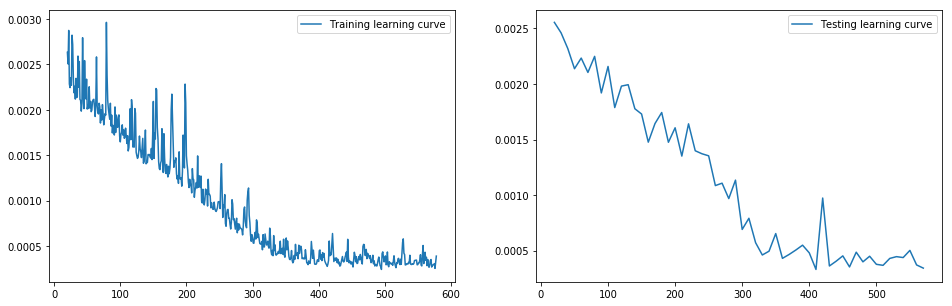

In [46]:
start = 20
plt.rcParams['figure.figsize'] = (16,5)

plt.subplot(1,2,1)
plt.plot(range(i)[start:], cost_train_list[start:], 
         label="Training learning curve")
plt.legend()

plt.subplot(1,2,2)
plt.plot(range(0,i,n_iters_test)[start//n_iters_test:], cost_test_list[start//n_iters_test:], 
         label="Testing learning curve")
plt.legend()

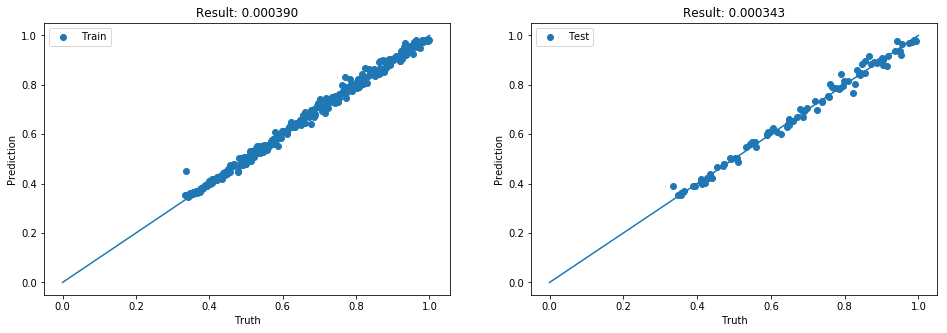

In [48]:
plt.subplot(1,2,1)
plt.title("Result: {:0.6f}".format(cost_train_list[-1]))
purity_pred = []
for j in range(n_samples_train):
    feed_dict = get_feed_dict(X_train[j])
    purity_pred.append(sess.run(purity_output, feed_dict=feed_dict))
#     df = df.append([{"Prediction": purity_pred, "Truth": Y_train[j]}])
# df.sort_values("Truth")
plt.scatter(Y_train, purity_pred, label="Train")
plt.plot([0,1],[0,1])
plt.xlabel("Truth")
plt.ylabel("Prediction")
plt.legend()

plt.subplot(1,2,2)
plt.title("Result: {:0.6f}".format(cost_test_list[-1]))
purity_pred = []
for j in range(n_samples_test):
    feed_dict = get_feed_dict(X_test[j])
    purity_pred.append(sess.run(purity_output, feed_dict=feed_dict))
#     df = df.append([{"Prediction": purity_pred, "Truth": Y_train[j]}])
# df.sort_values("Truth")
plt.scatter(Y_test, purity_pred, label="Test")
plt.plot([0,1],[0,1])
plt.xlabel("Truth")
plt.ylabel("Prediction")
plt.legend()

# plt.savefig("images/experiment_12/truth-predict.png")

## Debug

In [ ]:
feed_dict = get_feed_dict(X_train[0])
red_state = engine.run('tf', cutoff_dim=cutoff, eval=False, modes=0)
my_dm = sess.run(red_state.dm(), feed_dict=feed_dict)

In [ ]:
np.trace(my_dm)